In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


#train and test data directory
data_dir = "/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/dataset/Training"
test_data_dir = "/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/dataset/Testing"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [79]:
img, label = dataset[0]
print(img.shape,label)


torch.Size([3, 150, 150]) 0


In [80]:
print("Follwing classes are there : \n",dataset.classes)


Follwing classes are there : 
 ['glioma', 'meningioma', 'notumor', 'pituitary']


Label : glioma


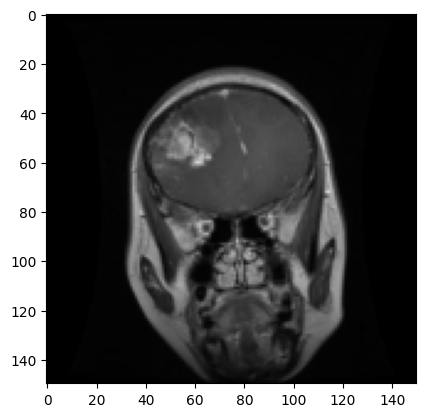

In [81]:
import matplotlib.pyplot as plt

def display_img(img, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))

#display the first image in the dataset
display_img(*dataset[0])

In [2]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128

print(f"Length of Train Data : {len(dataset)}")
print(f"Length of test Data : {len(test_dataset)}")


#load the train and test into batches.
train_dl = DataLoader(dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 5712
Length of test Data : 1311


In [98]:
import pickle
# Save the test DataLoader
with open('test_dl.pkl', 'wb') as test_dl_file:
    pickle.dump(test_dl, test_dl_file)

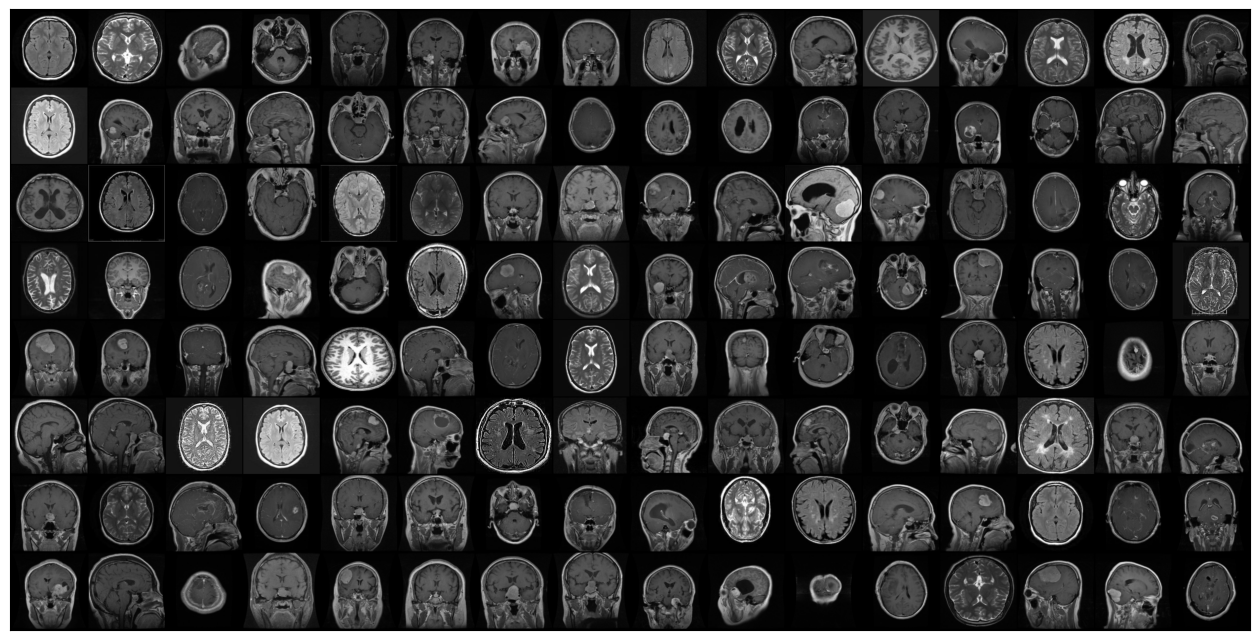

In [83]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, test_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
        
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['test_loss'], result['test_acc']))

In [ ]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,4)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [89]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

# Define the model
model = NaturalSceneClassification()

# Fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 1.4302, test_loss: 0.9154, test_acc: 0.6595
Epoch [1], train_loss: 0.6801, test_loss: 0.5641, test_acc: 0.7685
Epoch [2], train_loss: 0.5000, test_loss: 0.5022, test_acc: 0.7949
Epoch [3], train_loss: 0.4177, test_loss: 0.3910, test_acc: 0.8411
Epoch [4], train_loss: 0.3470, test_loss: 0.3408, test_acc: 0.8527
Epoch [5], train_loss: 0.2660, test_loss: 0.3273, test_acc: 0.8670
Epoch [6], train_loss: 0.2059, test_loss: 0.2399, test_acc: 0.9007
Epoch [7], train_loss: 0.1657, test_loss: 0.2734, test_acc: 0.8857
Epoch [8], train_loss: 0.1276, test_loss: 0.1923, test_acc: 0.9427
Epoch [9], train_loss: 0.1059, test_loss: 0.1776, test_acc: 0.9393
Epoch [10], train_loss: 0.0834, test_loss: 0.1773, test_acc: 0.9492
Epoch [11], train_loss: 0.0708, test_loss: 0.1622, test_acc: 0.9464
Epoch [12], train_loss: 0.0456, test_loss: 0.1777, test_acc: 0.9510
Epoch [13], train_loss: 0.0489, test_loss: 0.3227, test_acc: 0.9227
Epoch [14], train_loss: 0.0681, test_loss: 0.1489, test_ac

In [93]:
import pickle

# Assuming 'model' and 'history' are already defined and trained

# Save the model
with open('model1.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the history
with open('history1.pkl', 'wb') as history_file:
    pickle.dump(history, history_file)

In [7]:
import pickle

# Load the model
with open('model1.pkl', 'rb') as model_file:
    model = pickle.load(model_file)
    
# Load the history
with open('history1.pkl', 'rb') as history_file:
    history = pickle.load(history_file)


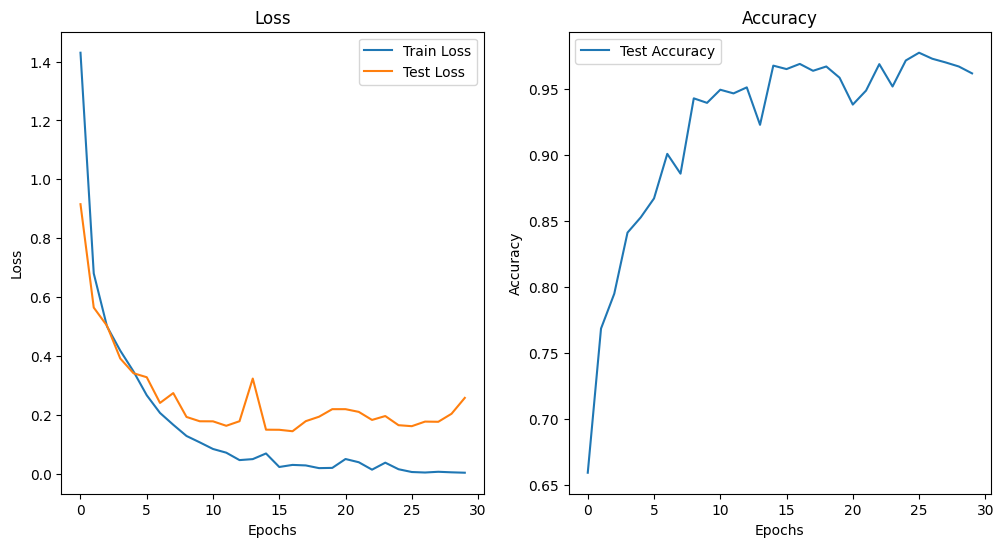

In [15]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    # Extract values from history
    train_acc = [x.get('train_acc') for x in history]
    train_loss = [x.get('train_loss') for x in history]
    test_loss = [x['test_loss'] for x in history]
    test_acc = [x['test_acc'] for x in history]
    
    epochs = range(len(train_loss))
    
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_acc, label='Test Accuracy')
    # plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Call the function to plot the curves
plot_loss_curves(history)

Test Accuracy: 0.9549961861174676


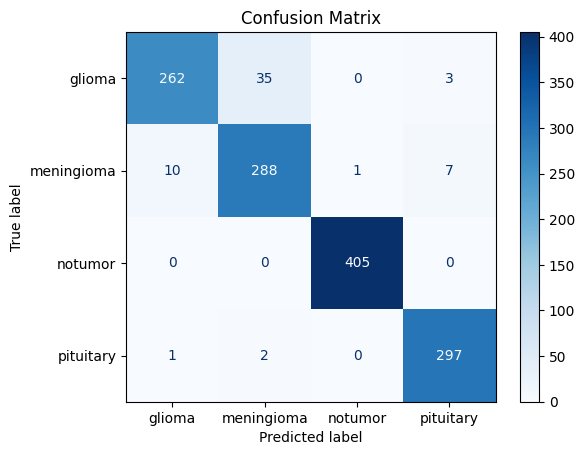

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Assuming 'model' is your trained model and 'test_dl' is your DataLoader for the test dataset

# Function to get predictions from the model
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Get the true labels and predictions
true_labels, final_predictions = get_predictions(model, test_dl)

# Calculate the accuracy
accuracy = accuracy_score(true_labels, final_predictions)
print(f"Test Accuracy: {accuracy}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, final_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()